In [1]:
## popular python packages
import numpy as np
import itertools as it
from scipy.linalg import svd
import matplotlib.pyplot as plt
from dask_quantumtinkerer import Cluster, cluster_options
import scipy.sparse.linalg as sla

# packages used here
import kwant
from kwant.operator import Density
import tinyarray as ta

import sys, os
sys.path.append(os.path.realpath(sys.path[0] + '/..'))
from rootpath import ROOT_DIR

# pre-defined functions
sys.path.append(os.path.join(ROOT_DIR + '/code'))
from optimization import Optimize, configuration, _fixed_potential_solver
import parameters
import tools as tl
from solvers import sort_eigen

# sys.path.append(os.path.join('/home/tinkerer/' + 'spin-qubit/'))


sys.path.append(os.path.join(ROOT_DIR + '/spin-qubit/'))
from Hamiltonian import discrete_system_coordinates
from potential import gate_potential


VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [2]:
options = cluster_options()
options.worker_cores = 2
options.worker_memory = 20
options.extra_path = "/home/srangaswamykup/trijunction_design/code/"

In [3]:
def _voltage_dict(x, dirichlet = False):
    voltages = {}

    voltages["left_1"] = x[0]
    voltages["left_2"] = voltages["left_1"]
    voltages["right_1"] = x[1]
    voltages["right_2"] = voltages["right_1"]
    voltages["top_1"] = x[2]
    voltages["top_2"] = voltages["top_1"]
    voltages["global_accumul"] = x[3]
    
    if dirichlet:
        for i in range(6):
            voltages["dirichlet_" + str(i)] = 0.0
        
    return voltages

# Y-shaped geometry

#### Parameters

In [4]:
import json
filename = 'config.json'
saveat = os.path.join(ROOT_DIR, 'code/')
with open(saveat + filename , 'r') as outfile:
    config = json.load(outfile)

In [5]:
optimize = Optimize(config, 
                    poisson_system = [],
                    linear_problem = [],
                    boundaries = [], 
                    grid = config['device']['grid_spacing']['twoDEG']
                   )

In [6]:
%%time
_, boundaries, poisson_system, linear_problem = optimize.changeconfig([])

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix
CPU times: user 4min 15s, sys: 14 s, total: 4min 29s
Wall time: 4min 29s


In [7]:
%%time

optimize.setconfig()

CPU times: user 968 ms, sys: 15.9 ms, total: 984 ms
Wall time: 981 ms


In [172]:
voltages = _voltage_dict([-0.0014, -0.0014, -0.0014, 3e-3], True)

charges = {}
potential = gate_potential(
        optimize.poisson_system,
        optimize.linear_problem,
        optimize.site_coords[:, [0, 1]],
        optimize.site_indices,
        voltages,
        charges,
        offset = optimize.offset[[0, 1]],
        grid_spacing = 1
    )
potential.update((x, y*-1) for x, y in potential.items())

In [173]:
mu = parameters.bands[0]
params = parameters.junction_parameters(m_nw=[mu, mu, mu], m_qd=0)
params.update(potential=potential)

In [174]:
from optimization import _closest_node

In [175]:
f_mu = optimize.f_params(**params)['mu']

In [176]:
import tinyarray as ta

In [177]:
def plot_f_mu(x, y):
    # x, y = optimize.trijunction.sites[i].pos
    # print(x, y)
    return f_mu(x, y)

In [178]:
kwant_sites = np.array(list(site.pos for site in optimize.trijunction.sites))

In [179]:
kwant_sites = np.array(list(site.pos for site in optimize.trijunction.sites))
to_plot = [plot_f_mu(*site) for site in kwant_sites]

In [180]:
grid_points = poisson_system.grid.points
voltage_regions = poisson_system.regions.voltage.tag_points

Text(0, 0.5, 'Y [10nm]')

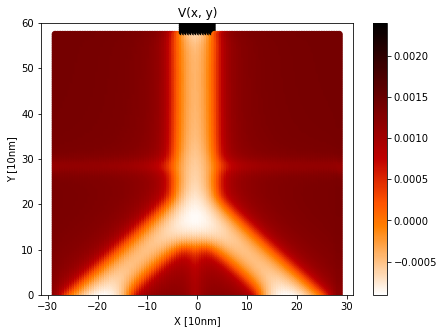

In [181]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
cax = ax.scatter(kwant_sites[:, 0]/10, kwant_sites[:, 1]/10, 
                 c = np.array(to_plot), cmap = 'gist_heat_r'
                );
ax.set_ylim(0, 60);
plt.colorbar(cax);
plt.title('V(x, y)');
plt.xlabel('X [10nm]')
plt.ylabel('Y [10nm]')
# plt.axis('equal')

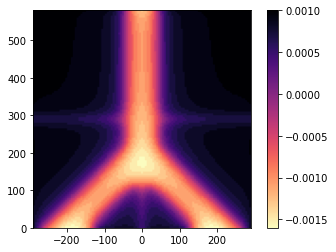

In [19]:
optimize.plot('POTENTIAL')

In [21]:
config

{'device': {'thickness': {'dielectric': 10,
   'twoDEG': 30,
   'gates': 20,
   'substrate': 50},
  'grid_spacing': {'twoDEG': 5,
   'normal': 10,
   'dielectric': 10,
   'air': 50,
   'gate': 5,
   'substrate': 10},
  'permittivity': {'metal': 5000,
   'twoDEG': 15,
   'air': 1.0,
   'Al2O3': 9.1,
   'substrate': 16}},
 'gate': {'L': 410, 'width': 120, 'gap': 40},
 'kwant': {'nwl': 1500, 'nww': 70}}

In [ ]:
depletion, accumulation = -0.0037, -0.0014

channels = np.array(['left', 'right', 'top'])
pairs = ['right-top', 'left-top', 'left-right']
pairs_voltages = {}

args = optimize.params(pairs[0])
initial_condition = {}

print('Optimizing voltages for all pairs')

for i, pair in enumerate(pairs):

    initial_point = np.array([-0.0014, -0.0014, -0.0014, 3e-3])
    mask = np.ones((len(initial_point) - 1, ), dtype = bool)
    depletion_index = np.where(channels == list(set(channels) - set(pair.split('-')))[0])
    mask[depletion_index] = False
    initial_point[depletion_index] = depletion
    if bool(i):
        initial_point[:-1][mask] = accumulation
        initial_point[-1] = global_V

    initial_condition[pair] = initial_point

    # print(f'initial_point {initial_point}')
    # print(f'optimizing pair {pair}')
    pairs_voltages[pair] = optimize.dep_acc_voltages(pair, initial_point)

    depletion = pairs_voltages[pair][depletion_index]
    accumulation = pairs_voltages[pair][:-1][mask]
    global_V = pairs_voltages[pair][-1]


#         
voltages = [_voltage_dict(x, True) for x in list(pairs_voltages.values())]

print('Optimizing phase')

# cluster_dashboard_link = "http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/"

# max_phis = optimize.optimalphase(
#             voltages,
#             Cluster = Cluster,
#             nnodes = 20,
#             cluster_options = options,
#             cluster_dashboard_link = cluster_dashboard_link,
            
# )            

# optimal_phis = optimize.optimal_phis


Optimizing voltages for all pairs
`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 5, CG iterations: 0, optimality: 0.00e+00, constraint violation: 0.00e+00, execution time: 0.0078 s.
`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 5, CG iterations: 0, optimality: 0.00e+00, constraint violation: 0.00e+00, execution time: 0.0025 s.


In [81]:
optimize.set_voltages(list(_voltage_dict(np.array([-0.0014, -0.0014, -0.0037, 3e-3]), False).values()), find_mlwf = False)

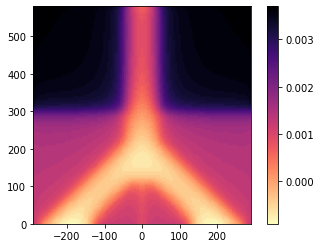

In [82]:
optimize.plot('POTENTIAL')

In [ ]:
params = parameters.junction_parameters(m_nw=parameters.bands[0] * np.ones(3))

potentials = []
arms = ["left", "right", "top"]


for voltage in voltages:
    charges = {}
    potential = gate_potential(
        optimize.poisson_system,
        optimize.linear_problem,
        optimize.site_coords[:, [0, 1]],
        optimize.site_indices,
        voltage,
        charges,
        offset=optimize.offset[[0, 1]],
        grid_spacing=1,
    )

    potential.update((x, y*-1) for x, y in potential.items())
    potentials.append(potential)

phases = np.linspace(0, 2, 100) * np.pi

phis1 = [{"phi1": phi, "phi2": 0} for phi in phases]
phis2 = [{"phi2": phi, "phi1": 0} for phi in phases]
phis = [phis2, phis2, phis1]

phase_results = []

In [ ]:
import dask.bag as db

In [ ]:
with Cluster(options) as cluster:
    cluster.scale(n=20)
    client = cluster.get_client()
    print(cluster_dashboard_link + cluster.dashboard_link[17:])
    for potential, phi in zip(potentials, phis):
        params.update(potential=potential)
        solver = _fixed_potential_solver(
            optimize.trijunction, optimize.f_params, params, eigenvecs=False
        )
        args_db = db.from_sequence(phi)
        result = args_db.map(solver).compute()

        energies = []
        for aux, _ in result:
            energies.append(aux)
        phase_results.append(energies)


0 0.0
[-7.71907775e-05 -6.19748904e-05 -6.17848530e-05 -5.91094845e-05
 -4.55130774e-05 -2.58991202e-05 -2.44924308e-05 -2.29052502e-05
 -1.89945706e-05 -1.67681895e-05  1.67681895e-05  1.89945706e-05
  2.29052502e-05  2.44924308e-05  2.58991202e-05  4.55130774e-05
  5.91094845e-05  6.17848530e-05  6.19748904e-05  7.71907775e-05]


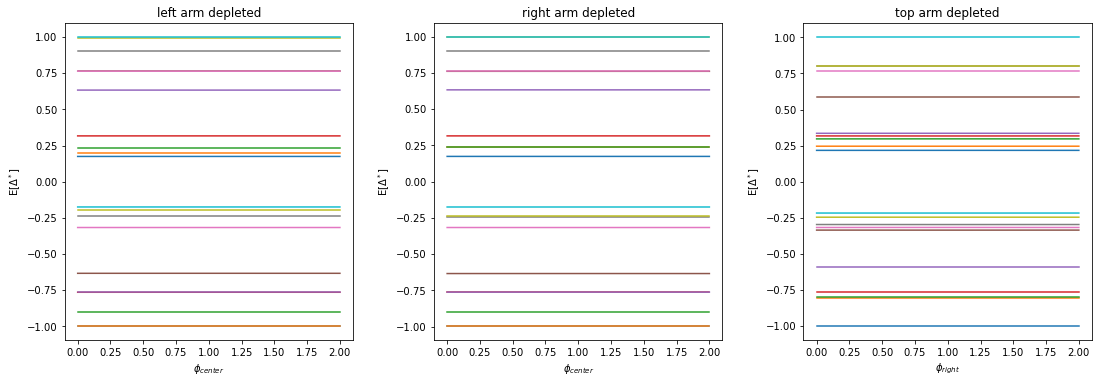

In [188]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
fig.tight_layout(w_pad=5)
i = 0
titles = ["left arm depleted", "right arm depleted", "top arm depleted"]
phis_labels = [r"$\phi_{center}$", r"$\phi_{center}$", r"$\phi_{right}$"]
peaks = []

solver = _fixed_potential_solver(
    optimize.trijunction, optimize.f_params, params, eigenvecs=False
)
topo_gap = solver(phis[0][0])[0][-1]

try:
    for energies in phase_results:
        energies = np.array(energies)
        for level in energies.T:
            ax[i].plot(phases / np.pi, level / topo_gap)
        # ax[i].vlines(x=max_phis[i], ymin=-1, ymax=1)
        ax[i].set_title(titles[i])
        ax[i].set_ylabel(r"E[$\Delta^*]$")
        ax[i].set_xlabel(phis_labels[i])
        i += 1
except AttributeError:
    print("Please calculate optimal phases first")

In [107]:
from tools import find_resonances

In [109]:
max_phis_id = []
for pair in phase_results:
    max_phis_id.append(
        find_resonances(energies=np.array(pair), n=20, sign=-1, i=-1)[1]
    )
# max_phis_id = np.array(max_phis_id).flatten()
# max_phis = self.phases[max_phis_id] / np.pi
# self.max_phis = max_phis

In [113]:
max_phis_id

[array([ 1,  3,  6,  9, 12, 16, 20, 28, 31, 34, 38, 40, 42, 49, 53, 57, 61,
        63, 66, 70, 72, 75, 77, 79, 84, 89, 96, 98]),
 array([ 5,  8, 10, 12, 15, 18, 21, 23, 26, 30, 32, 34, 38, 41, 45, 48, 51,
        53, 59, 62, 67, 69, 72, 74, 79, 81, 84, 86, 88, 91, 93, 97]),
 array([49])]

# Parallel simulation

In [39]:
def optimize_thickness_gap():
    
    def solver(*argv):
        
        thickness, gap = argv[0][0:]
        
        
        ROOT_DIR = '/home/srangaswamykup/trijunction_design/'
        sys.path.append(os.path.join(ROOT_DIR + 'spin-qubit/'))
        
        sys.path.append(os.path.join(ROOT_DIR + 'code/'))
        from potential import gate_potential
        from optimization import _fixed_potential_solver, Optimize
        import parameters
        from solvers import sort_eigen
        
        import json, pickle
        filename = 'config.json'
        saveat = os.path.join(ROOT_DIR, 'code/')
        with open(saveat + filename , 'r') as outfile:
            config = json.load(outfile)
            
        print('configuration file downloaded')
        
        # config, boundaries, poisson_system, linear_problem = configuration(config)
        optimize = Optimize(config, 
                            poisson_system = [],
                            linear_problem = [],
                            boundaries = [], 
                            length_unit = 1e-8
                           )
        
        
        print('Optimization instantiated')
        
        change_config = [{'device':{'thickness': {'dielectric': thickness}}}, {'gate':{'width': gap}}]
        
        _, boundaries, poisson_system, linear_problem = optimize.changeconfig(change_config)
        
        
        print('Device configuration changed')

        depletion, accumulation = -0.0037, -0.0014

        channels = np.array(['left', 'right', 'top'])
        pairs = ['right-top', 'left-top', 'left-right']
        pairs_voltages = {}

        args = optimize.params(pairs[0])
        initial_condition = {}

        print('Optimizing voltages for all pairs')

        for i, pair in enumerate(pairs):

            initial_point = np.array([-0.0014, -0.0014, -0.0014, 3e-3])
            mask = np.ones((len(initial_point) - 1, ), dtype = bool)
            depletion_index = np.where(channels == list(set(channels) - set(pair.split('-')))[0])
            mask[depletion_index] = False
            initial_point[depletion_index] = depletion
            if bool(i):
                initial_point[:-1][mask] = accumulation
                initial_point[-1] = global_V

            initial_condition[pair] = initial_point

            # print(f'initial_point {initial_point}')
            # print(f'optimizing pair {pair}')
            pairs_voltages[pair] = optimize.dep_acc_voltages(pair, initial_point)

            depletion = pairs_voltages[pair][depletion_index]
            accumulation = pairs_voltages[pair][:-1][mask]
            global_V = pairs_voltages[pair][-1]


#         
        voltages = [_voltage_dict(x, True) for x in list(pairs_voltages.values())]

        print('Optimizing phase')

        try:
            max_phis = optimize.optimalphase(
                        voltages
            )            

            optimal_phis = optimize.optimal_phis

            filename = 'phis_' + str(thickness) + '_' + str(gap) + '.pkl'
            with open("/home/srangaswamykup/trijunction_design/results/" + filename, 'wb') as outfile:
                pickle.dump(optimal_phis, outfile)

            optimize.params('right-top', 
                            optimal_phis=optimal_phis, 
                            voltages = voltages[0]
                           )
            # optimize.set_voltages(list(_voltage_dict(pairs_voltages['right-top']).values()), 
            #                       find_mlwf = True
            #                      )

            pair_indices = {
                        "right-top": [1, 2],
                        "left-right": [0, 1],
                        "left-top": [0, 2],

                    }


            for _, pair in enumerate(pairs):

                optimal_voltages = optimize.optimize_gate([pair], [initial_condition[pair]], 
                                                      optimal_phis = optimal_phis)

                # optimize.params(pair, optimal_phis=optimal_phis)

                voltages = _voltage_dict(optimal_voltages[pair].x, True)

                charges = {}
                potential = gate_potential(
                        poisson_system,
                        linear_problem,
                        optimize.site_coords[:, [0, 1]],
                        optimize.site_indices,
                        voltages,
                        charges,
                        offset = optimize.offset[[0, 1]],
                        grid_spacing = optimize.length_unit
                    )

                potential.update((x, y*-1) for x, y in potential.items())

                summed_ham = sum(
                [
                        optimize.linear_ham[key] * voltages[key]
                        for key, value in optimize.linear_ham.items()
                    ]
                )

                tight_binding_hamiltonian = optimize.base_hamiltonian + summed_ham


                eigval, eigvec = sort_eigen(sla.eigsh(tight_binding_hamiltonian.tocsc(), 
                                                                   k=6, sigma = 0))

                lowest_e_indices = np.argsort(np.abs(eigval))[: 6]
                lowest_e_energies = eigval[lowest_e_indices]
                coupled_states = eigvec.T[:, lowest_e_indices].T

                # Overlap matrix
                decoupled_states = optimize.mlwf
                S = coupled_states @ decoupled_states.T.conj()

                # Unitary matrix using SVD
                U, _, Vh = svd(S)
                S_prime = U @ Vh

                # Transform coupled Hamiltonian to Majorana basis
                coupled_ham = S_prime.T.conj() @ np.diag(lowest_e_energies) @ S_prime

                phases = np.linspace(0, 2, 100) * np.pi

                phis1 = [{"phi1": phi, "phi2": 0} for phi in phases]
                phis2 = [{"phi2": phi, "phi1": 0} for phi in phases]
                phis = [phis2, phis2, phis1]

                mu = parameters.bands[0]
                params = parameters.junction_parameters(m_nw=[mu, mu, mu], m_qd=0)
                params.update(potential=potential)

                solver = _fixed_potential_solver(
                    optimize.trijunction, optimize.f_params, params, eigenvecs=False
                )
                topo_gap = solver(phis[0][0])[0][-1]

                coupled_pair = pair_indices[pair]

                coupling_strength = np.abs(coupled_ham[2:5, 2:5][coupled_pair[0], coupled_pair[1]]) / topo_gap

                filename = str(thickness) + '_' + str(gap) + '_' + str(coupled_pair[0]) + '_' + str(coupled_pair[1]) + '.pkl'
                with open("/home/srangaswamykup/trijunction_design/results/" + filename, 'wb') as outfile:
                    pickle.dump(coupling_strength, outfile)

            return coupling_strength
        
        except IndexError:
            error = 'Index error'
            return error

    return solver


In [ ]:
cluster_dashboard_link = "http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/"

import dask.bag as db
with Cluster(options) as cluster:
    cluster.scale(n=len(sequence))
    client = cluster.get_client()
    print(cluster_dashboard_link + cluster.dashboard_link[17:])
    solver = optimize_thickness_gap()
    args_db = db.from_sequence(sequence)
    result = args_db.map(solver).compute()

http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/8000/clusters/8533abbea10048429485c2c7d9afcd3c/status


#### Results

In [242]:
from potential import gate_potential

In [ ]:
voltages = _voltage_dict(optimal_voltages[pairs[0]].x)

In [243]:
charges = {}
potential = gate_potential(
        poisson_system,
        linear_problem,
        optimize.site_coords[:, [0, 1]],
        optimize.site_indices,
        voltages,
        charges,
        offset = optimize.offset[[0, 1]],
        grid_spacing = optimize.length_unit
    )

potential.update((x, y*-1) for x, y in potential.items())

In [244]:
mu = parameters.bands[0]
params = parameters.junction_parameters(m_nw=[mu, mu, mu], m_qd=0)
params.update(potential=potential)

In [245]:
f_mu = optimize.f_params(**params)['mu']

In [246]:
def plot_f_mu(i):
    x, y = optimize.trijunction.sites[i].pos
    return f_mu(x, y)

In [247]:
kwant_sites = np.array(list(site.pos for site in optimize.trijunction.sites))

In [248]:
to_plot = [plot_f_mu(i) for i in range(len(kwant_sites))]

In [249]:
grid_points = poisson_system.grid.points
voltage_regions = poisson_system.regions.voltage.tag_points

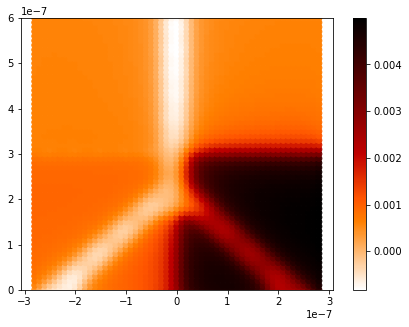

In [250]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
cax = ax.scatter(kwant_sites[:, 0 ], kwant_sites[:, 1], 
                 c = np.array(to_plot), cmap = 'gist_heat_r'
                );
ax.set_ylim(0, 0.6e-6);
plt.colorbar(cax);
# plt.axis('equal')

In [ ]:
summed_ham = sum(
[
        optimize.linear_ham[key] * voltages[key]
        for key, value in optimize.linear_ham.items()
    ]
)

tight_binding_hamiltonian = optimize.base_hamiltonian + summed_ham


eigval, eigvec = sort_eigen(sla.eigsh(tight_binding_hamiltonian.tocsc(), 
                                                   k=6, sigma = 0))

lowest_e_indices = np.argsort(np.abs(eigval))[: 6]
lowest_e_energies = eigval[lowest_e_indices]
coupled_states = eigvec.T[:, lowest_e_indices].T

# Overlap matrix
decoupled_states = optimize.mlwf
S = coupled_states @ decoupled_states.T.conj()

# Unitary matrix using SVD
U, _, Vh = svd(S)
S_prime = U @ Vh

# Transform coupled Hamiltonian to Majorana basis
coupled_ham = S_prime.T.conj() @ np.diag(lowest_e_energies) @ S_prime

phases = np.linspace(0, 2, 100) * np.pi

phis1 = [{"phi1": phi, "phi2": 0} for phi in phases]
phis2 = [{"phi2": phi, "phi1": 0} for phi in phases]
phis = [phis2, phis2, phis1]

solver = optimization._fixed_potential_solver(
    optimize.trijunction, optimize.f_params, params, eigenvecs=False
)
topo_gap = solver(phis[0][0])[0][-1]

In [255]:
print(np.abs((coupled_ham[2:5, 2:5])[0 , 2]) / topo_gap)

0.2000021182501158


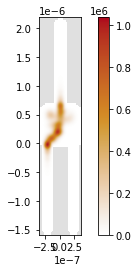

In [256]:
kwant.plotter.density(optimize.trijunction, optimize.densityoperator(coupled_states[-1]));

In [163]:
optimum_voltages = {}
with open("/home/tinkerer/trijunction-design/data/LR_voltages.pkl", 'rb') as infile:
    optimum_voltages['LR'] = pickle.load(infile)
    
with open("/home/tinkerer/trijunction-design/data/LC_voltages.pkl", 'rb') as infile:
    optimum_voltages['LC'] = pickle.load(infile)
    
with open("/home/tinkerer/trijunction-design/data/CR_voltages.pkl", 'rb') as infile:
    optimum_voltages['CR'] = pickle.load(infile)

100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


0.00013948485514774731


100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


0.00010258611045929488


100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


0.00011244328071718932


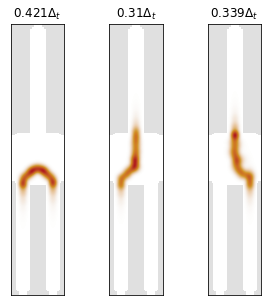

In [164]:
fig, ax = plt.subplots(1, 3, figsize = (5, 5), sharey = True)

coupling_strength = {}

for index, pairs in enumerate(zip([[0, 1], [0, 2], [1, 2]], ['LR', 'LC', 'CR'])):
    indices, pair = pairs
    
    base_hamiltonian, linear_ham = linear_Hamiltonian(poisson_params, 
                                                  kwant_params, 
                                                  params, 
                                                  list(voltage_regions.keys()),
                                                  phis = optimal_phis[pair])
    summed_ham = sum(
        [
            linear_ham[key] * optimum_voltages[pair][key]
            for key, value in linear_ham.items()
        ]
    )

    tight_binding_hamiltonian = base_hamiltonian + summed_ham


    eigval, eigvec = sort_eigen(sparse.linalg.eigsh(tight_binding_hamiltonian.tocsc(), 
                                                       k=6, sigma = 0))

    lowest_e_indices = np.argsort(np.abs(eigval))[: 6]
    lowest_e_energies = eigval[lowest_e_indices]
    coupled_states = eigvec.T[:, lowest_e_indices].T

    
    cax = kwant.plotter.density(trijunction, density(coupled_states[-1]), ax = ax[index]);
    
    ax[index].set_xticks([])
    ax[index].set_yticks([])

    # Overlap matrix
    decoupled_states = mlwf
    S = coupled_states @ decoupled_states.T.conj()

    # Unitary matrix using SVD
    U, _, Vh = svd(S)
    S_prime = U @ Vh

    # Transform coupled Hamiltonian to Majorana basis
    coupled_ham = S_prime.T.conj() @ np.diag(lowest_e_energies) @ S_prime

    print(np.abs((coupled_ham[2:5, 2:5])[indices[0], indices[1]]))
    
    
    coupling_strength[pair] = np.round(np.abs((coupled_ham[2:5, 2:5]/topo_gap)[indices[0], indices[1]]
                                                            ), 
                                                      3
                                                     )
    
    ax[index].set_title(r'${}\Delta_t$'.format(coupling_strength[pair]))

In [165]:
coupling_strength = {'LR': 0.421, 'LC': 0.31, 'CR': 0.339} #unit: Topological gap

{'LR': 0.421, 'LC': 0.31, 'CR': 0.339}